## Классификация по задержкам отправления

В ходе проделанной работы по предсказанию DEPARTURE_DELAY мы достигли потолка, поскольку нет явных признаков, позволяющих спрогнозировать задержку. В связи с этим было принято решение вернуться к самому началу - конструированию признаков и составлению работего датасета.

Углубившись в проблемматику авиаперевозок, были выделены следующие основные причины опозданий авиарейсов:
1) Плохие погодные условия

2) Поздний прилёт самолёта с предыдущего рейса

3) Неисправности самих самолётов

4) Тенденции отдельных авиакомпаний задерживать рейсы

Для учёта этих факторов были приняты следующие меры:

### Индекс задержек для авиакомпаний

Были собраны аналогичные данные по 2014 году, что позволило собрать небольшую историческую статистику по авиаперевозкам. Индекс задержек авиакомпаний высчитывался как отношение задержанных рейсов к общему количеству рейсов в течении года. По собственным соображениям, рейс будем считать задержанным, если DEPARTURE_DELAY > 5 минут

### Является ли день выходным

Как было видно из разведовательного анализа данных, больше всего вылетов было совершено в выходные дни. Логично предположить, что вероятность задержки рейсов в эти дни выше

### Статистика городов

Благодаря статистике за предыдущий год, можем посмотреть на тенденции задержек авиарейсов, сгруппированных по отдельным городам, месяцам и дням недели. Предполагаем, что, если в каком-то городе был задержан один рейс (например, из-за плохих погодных условий), то и последующие рейсы в этом городе так же могут быть отложены

### Прилёт самолёта с опозданием

Обычно, авиакомпании распределяют рейсы так, чтобы между ними был примерно час времени, для подготовки самолёта к следующему вылету. Соответственно, если самолёт прилетел позже запланированного времени, то и шансы на его опоздание к отлёту на следующий рейс повышаются

### Индекс опозданий самолётов

Воспользовавшись данными за предыдущий год, был подсчитан индекс опозданий для самолётов. Делается это в предположении, что некоторые самолёты старые, поэтому часто нуждаются в техническом обслуживании. Из-за этого повышается вероятность задержки рейса у конкретного самолёта

### Погода

Со стороннего ресурса были скачаны данные погоды за 2015 год по кажжому из городов отправления с периодичностью в 1 час

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objs as go
from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display
from tqdm import tqdm
%matplotlib inline
pd.options.display.max_columns = 50

In [1]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, precision_recall_curve
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, ARDRegression
from sklearn.svm import LinearSVR, SVC, LinearSVC
from keras.models import Sequential
from keras.layers import Dense, ReLU
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import VotingClassifier

In [3]:
def plot_train_val_loss(history, epochs):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    
    epochs = range(1, epochs + 1)

    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')

    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [4]:
def plot_pr_curve(y_true, prediction):
    precision, recall, thresholds = precision_recall_curve(y_true, prediction)
    thresholds = [0] + thresholds.tolist()
    plt.plot(thresholds, precision, label='precision');
    plt.plot(thresholds, recall, label='recall');
    plt.legend(); plt.xlabel('Threshold'); plt.ylabel('Precision or recall');
    plt.title('Precision and recall for unbalanced dataset');

In [5]:
%%time
flights = pd.read_csv('dep_delay_df.csv')
flights.drop(['YEAR','FLIGHTS', 'DEP_DELAY_GROUP'], axis=1, inplace=True)
flights.FIRST_DEP_TIME.fillna(0, inplace=True)
#flights.TOTAL_ADD_GTIME.fillna(0, inplace=True)
flights.LONGEST_ADD_GTIME.fillna(0, inplace=True)
#df.drop('LONGEST_ADD_GTIME', axis=1, inplace=True)
flights.drop('TOTAL_ADD_GTIME', axis=1, inplace=True)
#df.drop('FIRST_DEP_TIME', axis=1, inplace=True)
flights.STD_DELAY.fillna(0, inplace=True)
flights.MEAN_DELAY.fillna(0, inplace=True)
flights.MAX_DELAY.fillna(0, inplace=True)
flights.MIN_DELAY.fillna(0, inplace=True)
flights.COUNT.fillna(0, inplace=True)
flights['25%_DELAY'].fillna(0, inplace=True)
flights['50%_DELAY'].fillna(0, inplace=True)
flights['75%_DELAY'].fillna(0, inplace=True)
flights.dropna(inplace=True)

CPU times: user 37.3 s, sys: 27.3 s, total: 1min 4s
Wall time: 1min 20s


In [6]:
flights.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,TAIL_NUM,FLIGHT_MUNBER,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,DISTANCE,FIRST_DEP_TIME,LONGEST_ADD_GTIME,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,tempC,windspeedKmph,winddirDegree,...,cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,weatherCode_dest,COUNT,MEAN_DELAY,STD_DELAY,MIN_DELAY,25%_DELAY,50%_DELAY,75%_DELAY,MAX_DELAY,WEEKEND,LATE_AIRLINE_INDEX,LATE_TAIL_INDEX,LATE_ARR,IN_FLIGHTS_H,OUT_FLIGHTS_H,LATE_DEP_1,LATE_DEP_2,LATE_DEP_3,LATE_DEP_4
0,4,23,4,805608,907675,165,786276,86124,230321,679992,1210,-8.0,1414,1440.0,0.0,0.0,8,3,0.0,13.8,3,29,8,12,324,...,23,8,-1,5,17,5,200.0,10.0,-1.600000,8.408990,-11.0,-5.5,-3.0,-0.50,20.0,0,0.119103,0.108824,0.0,38,66,0.0,0.0,0.0,0.0
1,4,24,5,805608,625140,165,786276,86124,230321,679992,1210,4.0,1414,1440.0,0.0,0.0,11,3,0.0,12.2,3,36,11,13,90,...,46,11,-1,10,22,10,176.0,19.0,22.157895,49.944706,-9.0,-3.0,-1.0,12.00,140.0,0,0.119103,0.123330,0.0,37,65,1.0,1.0,0.0,0.0
2,4,25,6,805608,140380,165,786276,86124,230321,679992,1210,44.0,1414,1440.0,0.0,0.0,7,4,0.0,9.8,2,44,5,14,60,...,100,5,4,2,22,2,113.0,11.0,1.636364,16.698938,-7.0,-5.5,-4.0,-0.50,51.0,1,0.119103,0.136511,0.0,33,53,0.0,1.0,0.0,0.0
3,4,26,7,805608,869737,165,786276,86124,230321,679992,1210,-5.0,1414,1440.0,0.0,0.0,8,3,0.0,13.9,3,52,8,17,15,...,3,8,2,6,23,6,116.0,22.0,17.272727,37.386249,-8.0,-4.0,-1.5,15.50,128.0,1,0.119103,0.110572,0.0,37,63,0.0,1.0,1.0,0.0
4,4,27,1,805608,556272,165,786276,86124,230321,679992,1210,9.0,1414,1440.0,0.0,0.0,7,3,0.0,13.9,3,59,7,27,13,...,14,7,3,3,39,3,113.0,18.0,8.333333,26.648033,-6.0,-4.0,-2.5,2.25,94.0,0,0.119103,0.119418,1.0,38,66,1.0,1.0,0.0,0.0


In [7]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [8]:
missing_values_table(flights)

Your selected dataframe has 55 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [9]:
scaler = StandardScaler()

In [10]:
flights.shape

(4738774, 55)

### Пробуем найти основную часть задержек

In [12]:
# Calculate first and third quartile
first_quartile = flights['DEP_DELAY'].describe()['25%']
third_quartile = flights['DEP_DELAY'].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

# Remove outliers
data = flights[(flights['DEP_DELAY'] > (first_quartile - 3/2 * iqr)) &
            (flights['DEP_DELAY'] < (third_quartile + 3/2 * iqr))].copy()

<AxesSubplot:xlabel='DEP_DELAY', ylabel='Count'>

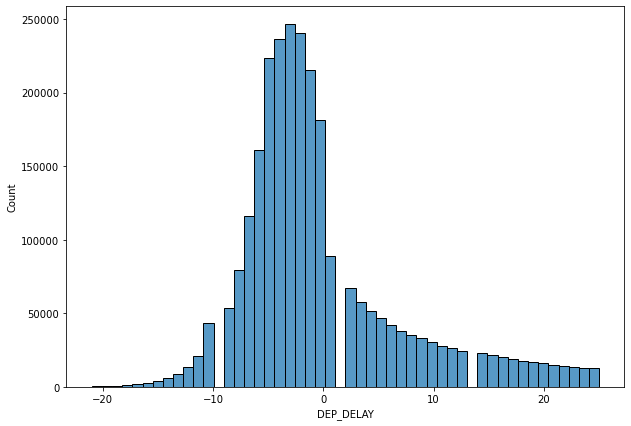

In [13]:
plt.figure(figsize=(10,7))
sns.histplot(data.DEP_DELAY, bins=50)

In [14]:
data.shape

(2631868, 55)

На гистограмме хорошо видно, что большая часть задержек находится левее нуля. Это значит, что самолёт вылетел чуть раньше запланированного. Поэтому, попробуем разбить выборку на 2 класса: DEPARTURE_DELAY < 15 минут и DEPARTURE_DELAY >= 15 минут.

Забегая вперёд, попробуем построить линейную регрессию на полученных данных и посмотреть на результат.

In [14]:
data.dropna(inplace=True)
X = data.drop(['DEP_DELAY', 'DEP_DELAY_GROUP'], axis=1)
y = data.DEP_DELAY
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
%%time
lin = LinearRegression()
lin.fit(X_train, y_train)

CPU times: user 15.2 s, sys: 1.65 s, total: 16.8 s
Wall time: 5.82 s


LinearRegression()

In [16]:
prediction = lin.predict(X_test)
mean_absolute_error(y_test, prediction)

5.061955725299539

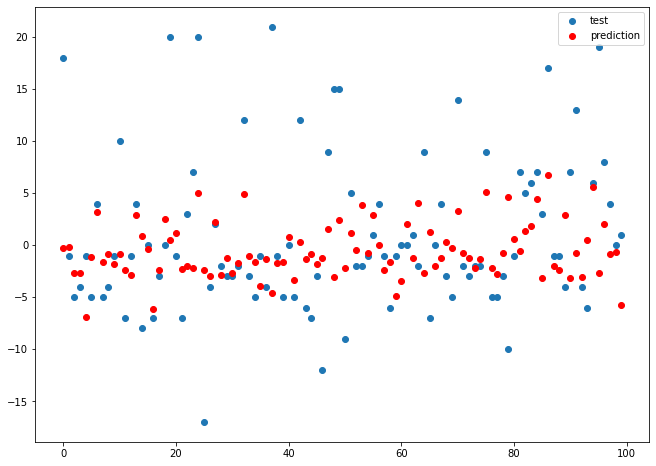

In [17]:
plt.figure(figsize=(11,8))
plt.scatter(range(100), y_test[:100], label='test')
plt.scatter(range(100), prediction[:100], color='red', label='prediction')
plt.legend()

Ещё одна регрессия

In [18]:
%%time
ard = ARDRegression()
ard.fit(X_train, y_train)

CPU times: user 3min 17s, sys: 9.9 s, total: 3min 26s
Wall time: 1min 1s


ARDRegression()

In [19]:
prediction = ard.predict(X_test)
mean_absolute_error(y_test, prediction)

5.06194819973043

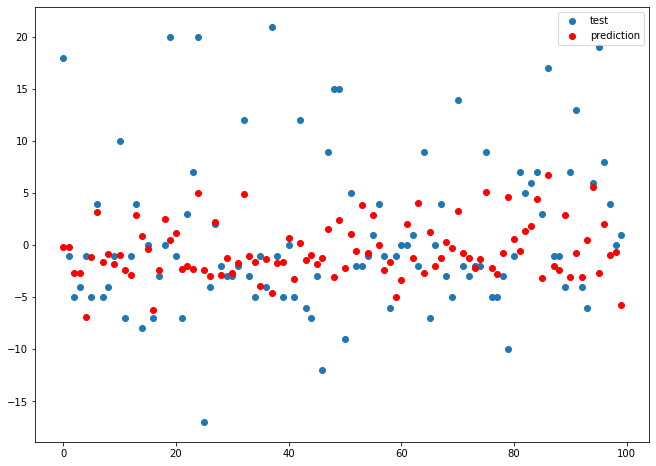

In [20]:
plt.figure(figsize=(11,8))
plt.scatter(range(100), y_test[:100], label='test')
plt.scatter(range(100), prediction[:100], color='red', label='prediction')
plt.legend()

Посмотрим на фаворита - метод опорных векторов

In [22]:
%%time
svr = LinearSVR()
svr.fit(X_train, y_train)

CPU times: user 22min 5s, sys: 1.69 s, total: 22min 7s
Wall time: 22min 10s


LinearSVR()

In [23]:
prediction = svr.predict(X_test)
mean_absolute_error(y_test, prediction)

4.694620644280556

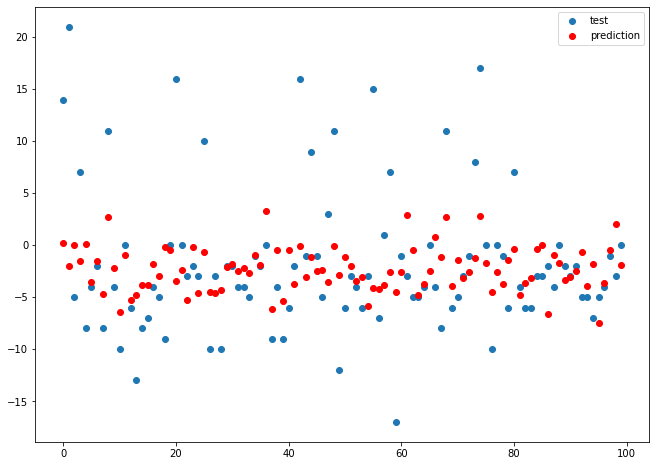

In [24]:
plt.figure(figsize=(11,8))
plt.scatter(range(100), y_test[:100], label='test')
plt.scatter(range(100), prediction[:100], color='red', label='prediction')
plt.legend()

Нейросетевая регрессия

In [24]:
network = Sequential()
network.add(Dense(32, input_dim=X_train.shape[1], activation='relu', kernel_initializer='he_normal'))
network.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
network.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
network.add(Dense(1))

network.compile(optimizer="adam", loss="mse")

history = network.fit(X_train, y_train, epochs=15, validation_split=0.2, batch_size=256)

Epoch 1/15
6169/6169 [==============================] - 17s 3ms/step - loss: 46.3779 - val_loss: 44.1868
Epoch 2/15
6169/6169 [==============================] - 16s 3ms/step - loss: 44.0350 - val_loss: 43.6300
Epoch 3/15
6169/6169 [==============================] - 16s 3ms/step - loss: 43.6236 - val_loss: 43.3655
Epoch 4/15
6169/6169 [==============================] - 16s 3ms/step - loss: 43.4271 - val_loss: 43.2875
Epoch 5/15
6169/6169 [==============================] - 16s 3ms/step - loss: 43.2631 - val_loss: 43.3206
Epoch 6/15
6169/6169 [==============================] - 16s 3ms/step - loss: 43.1354 - val_loss: 43.1100
Epoch 7/15
6169/6169 [==============================] - 16s 3ms/step - loss: 42.9762 - val_loss: 43.0654
Epoch 8/15
6169/6169 [==============================] - 16s 3ms/step - loss: 42.8592 - val_loss: 43.0075
Epoch 9/15
6169/6169 [==============================] - 17s 3ms/step - loss: 42.9499 - val_loss: 42.9555
Epoch 10/15
6169/6169 [==============================] 

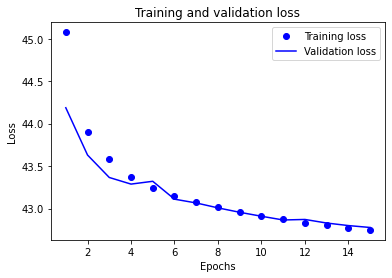

In [25]:
plot_train_val_loss(history, 15)

In [26]:
prediction = network.predict(X_test)
mean_absolute_error(y_test, prediction)

4.701193863679527

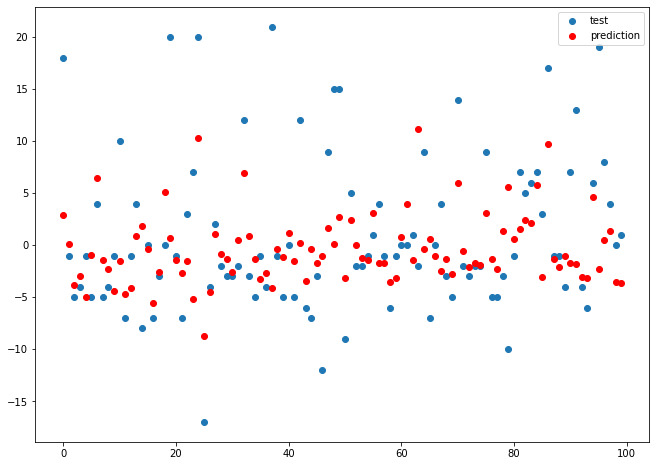

In [27]:
plt.figure(figsize=(11,8))
plt.scatter(range(100), y_test[:100], label='test')
plt.scatter(range(100), prediction[:100], color='red', label='prediction')
plt.legend()

## Разметка данных

In [11]:
def mark_outliers(x):
    if (x >= 15):
        return 1
    else:
        return 0

In [12]:
flights['target'] = flights.DEP_DELAY.apply(mark_outliers)

In [13]:
flights.target.value_counts()

0    3873381
1     865393
Name: target, dtype: int64

<AxesSubplot:xlabel='DEP_DELAY', ylabel='Count'>

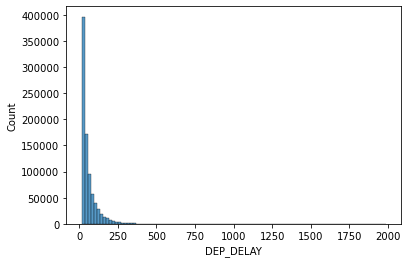

In [14]:
sns.histplot(data=flights[flights.target == 1], x='DEP_DELAY', bins=100)

<AxesSubplot:xlabel='DEP_DELAY', ylabel='Count'>

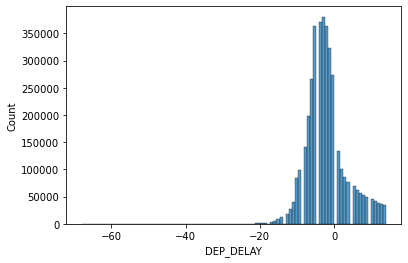

In [15]:
sns.histplot(data=flights[flights.target == 0], x='DEP_DELAY', bins=100)

## Прогноз

In [16]:
flights.target = flights.target.map(int)

In [17]:
def fit_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model.fit(X_train, y_train)
    print(classification_report(y_test, model.predict(X_test)))
    return model

In [18]:
%%time
logit = fit_model(LogisticRegression(max_iter=200), 
                  flights.drop(['DEP_DELAY', 'target', 'LONGEST_ADD_GTIME'], axis=1),
                  flights.target)

              precision    recall  f1-score   support

           0       0.88      0.96      0.92    968190
           1       0.69      0.40      0.51    216504

    accuracy                           0.86   1184694
   macro avg       0.79      0.68      0.71   1184694
weighted avg       0.84      0.86      0.84   1184694

CPU times: user 1min 47s, sys: 26.1 s, total: 2min 13s
Wall time: 2min 41s


In [19]:
logit_feature = pd.DataFrame({"features": flights.drop(['DEP_DELAY', 'target', 'LONGEST_ADD_GTIME'], axis=1).columns})
tmp = pd.DataFrame({'col': logit.coef_[0]})
logit_feature = pd.concat([logit_feature, tmp], axis=1)
logit_feature.style.background_gradient()

,features,col
0,MONTH,0.000619
1,DAY,-0.013609
2,DAY_OF_WEEK,0.002660
3,AIRLINE,0.019561
4,TAIL_NUM,-0.003376
5,FLIGHT_MUNBER,-0.061524
6,ORIGIN,-0.010309
7,ORIGIN_CITY_NAME,-0.012970
8,DEST,0.033578
9,DEST_CITY_NAME,-0.010354


In [23]:
logit_feature.sort_values(by='col', inplace=True)

In [24]:
bot = logit_feature.sort_values(by='col').head(5)
top = logit_feature.sort_values(by='col').tail(6)

In [32]:
trace = go.Bar(
    x=bot.append(top).features,
    y=bot.append(top).col,
    marker=dict(
        color = bot.append(top).col,
        colorscale='sunset',
        showscale=True
    )
)

data = [trace]
layout = go.Layout(xaxis=dict(tickangle=30),
                   yaxis = dict(title = 'Вес'),
                   width=1500,
                   height=700
                  )

fig = go.Figure(data=data, layout=layout)
fig.update_layout(
    font=dict(
        size=28,
    )
)
fig.show()

In [19]:
dict(zip(logit_feature.features, logit_feature.col))

{'MONTH': 0.0003979091725721135,
 'DAY': -0.013670600062808373,
 'DAY_OF_WEEK': 0.0026806015490646855,
 'AIRLINE': 0.018517467426937648,
 'TAIL_NUM': -0.003388495685222229,
 'FLIGHT_MUNBER': -0.0620309503521954,
 'ORIGIN': -0.010332544618512827,
 'ORIGIN_CITY_NAME': -0.012967877575765084,
 'DEST': 0.033790020085875,
 'DEST_CITY_NAME': -0.010369710166303203,
 'CRS_DEP_TIME': 0.3308882635197552,
 'CRS_ARR_TIME': 0.10109695559592288,
 'DISTANCE': 0.051555203836813196,
 'FIRST_DEP_TIME': 0.05276147813117536,
 'LONGEST_ADD_GTIME': 1.316581662433643,
 'maxtempC': -0.3457556569687187,
 'mintempC': -0.1866787413426417,
 'totalSnow_cm': 0.02815662904808601,
 'sunHour': 0.004596649426403422,
 'uvIndex': 0.015880858578297453,
 'moon_illumination': 0.01816867200080102,
 'tempC': 0.5106408987855785,
 'windspeedKmph': 0.1917044641634214,
 'winddirDegree': 0.028665036619953604,
 'weatherCode_origin': 0.02191009550692335,
 'precipMM': 0.04602411266354075,
 'humidity': 0.09128185194031402,
 'visibility

In [33]:
%%time
grad = fit_model(XGBClassifier(random_state=42, n_jobs=6, use_label_encoder=False),
                 flights.drop(['DEP_DELAY', 'target', 'LONGEST_ADD_GTIME'], axis=1),
                 flights.target)

[23:46:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.89      0.96      0.92    968190
           1       0.72      0.49      0.58    216504

    accuracy                           0.87   1184694
   macro avg       0.81      0.72      0.75   1184694
weighted avg       0.86      0.87      0.86   1184694

CPU times: user 1h 47min 35s, sys: 46.4 s, total: 1h 48min 21s
Wall time: 19min 3s


In [34]:
grad_feature = pd.DataFrame({"features": flights.drop(['DEP_DELAY', 'target', 'LONGEST_ADD_GTIME'], axis=1).columns})
tmp = pd.DataFrame({'col': grad.feature_importances_})
grad_feature = pd.concat([grad_feature, tmp], axis=1)
grad_feature.style.background_gradient()

,features,col
0,MONTH,0.006782
1,DAY,0.004037
2,DAY_OF_WEEK,0.003805
3,AIRLINE,0.012127
4,TAIL_NUM,0.000787
5,FLIGHT_MUNBER,0.002913
6,ORIGIN,0.002708
7,ORIGIN_CITY_NAME,0.003482
8,DEST,0.004735
9,DEST_CITY_NAME,0.004302


In [35]:
grad_feature.sort_values(by='col', inplace=True)

In [36]:
top = grad_feature.sort_values(by='col').tail(9)

In [37]:
trace = go.Bar(
    x=top.features,
    y=top.col,
    marker=dict(
        color = top.col,
        colorscale='matter', #RdPu
        showscale=True
    )
)

data = [trace]
layout = go.Layout(xaxis=dict(tickangle=30),
                   yaxis = dict(title = 'Вес'),
                   width=1500,
                   height=700
                  )

fig = go.Figure(data=data, layout=layout)
fig.update_layout(
    font=dict(
        size=28,
    )
)
fig.show()

Наиболее важным признаком для обеих моделей оказался LATE_ARR - был ли задержан прилёт самолёта с предыдущего рейса. Данный признак действительно имеет важное значение. Однако существуют ещё много факторов, которые не содержатся в исходном наборе данных. Например, время загрузки багажа, время обслуживания самолёта, его техническое состояние, ожидание пассажиров стыковочных рейсов и прочее. Даже погодные условия не так важны. Если случается сильная метель, ураган, грозы, то рейс, скорее всего отменят или перенесут на более поздний срок. Температура, влажность, осадки, давление не является проблемой для современных самолётов

In [20]:
X_train, X_test, y_train, y_test = train_test_split(flights.drop(['DEP_DELAY', 'target'], axis=1),
                 flights.target, random_state=42, shuffle=True)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
import keras

In [20]:
model = Sequential()
model.add(Dense(32, activation='relu', kernel_initializer='he_normal', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1,  activation='sigmoid', kernel_initializer='he_normal'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=128)

Epoch 1/10
14212/14212 [==============================] - 36s 2ms/step - loss: 0.3787 - val_loss: 0.3665
Epoch 2/10
14212/14212 [==============================] - 33s 2ms/step - loss: 0.3649 - val_loss: 0.3647
Epoch 3/10
14212/14212 [==============================] - 34s 2ms/step - loss: 0.3616 - val_loss: 0.3638
Epoch 4/10
14212/14212 [==============================] - 34s 2ms/step - loss: 0.3614 - val_loss: 0.3634
Epoch 5/10
14212/14212 [==============================] - 32s 2ms/step - loss: 0.3601 - val_loss: 0.3625
Epoch 6/10
14212/14212 [==============================] - 33s 2ms/step - loss: 0.3609 - val_loss: 0.3625
Epoch 7/10
14212/14212 [==============================] - 34s 2ms/step - loss: 0.3598 - val_loss: 0.3622
Epoch 8/10
14212/14212 [==============================] - 33s 2ms/step - loss: 0.3595 - val_loss: 0.3618
Epoch 9/10
14212/14212 [==============================] - 32s 2ms/step - loss: 0.3596 - val_loss: 0.3620
Epoch 10/10
14212/14212 [==============================

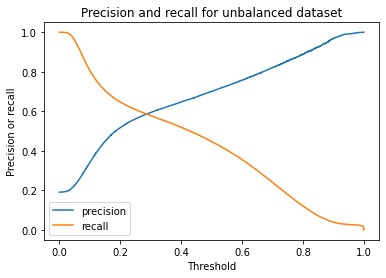

In [21]:
plot_pr_curve(y_test, model.predict(X_test))

In [22]:
p_network = model.predict(X_test)

In [23]:
def asd(x):
    if x > 0.28:
        return 1
    return 0

In [24]:
from tqdm import tqdm

In [30]:
test_score = []
for i in tqdm(range(len(y_test))):
    test_score.append(asd(p_network[i]))
    
print(classification_report(y_test, test_score))

100%|██████████| 757928/757928 [00:02<00:00, 273461.32it/s]


              precision    recall  f1-score   support

           0       0.90      0.90      0.90    613014
           1       0.58      0.59      0.59    144914

    accuracy                           0.84    757928
   macro avg       0.74      0.74      0.74    757928
weighted avg       0.84      0.84      0.84    757928



### Классификатор с голосованием

In [18]:
%%time
logit = LogisticRegression(max_iter=200, class_weight='balanced')
grad = XGBClassifier(random_state=42, n_jobs=6, use_label_encoder=False)
vot_clf = fit_model(VotingClassifier(estimators=[('logit', logit), ('grad', grad)], voting='soft'), 
                  flights.drop(['DEP_DELAY', 'target'], axis=1),
                  flights.target)

[15:06:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.91      0.92      0.92    968190
           1       0.63      0.59      0.61    216504

    accuracy                           0.86   1184694
   macro avg       0.77      0.76      0.76   1184694
weighted avg       0.86      0.86      0.86   1184694

CPU times: user 1h 18min 9s, sys: 32.6 s, total: 1h 18min 42s
Wall time: 14min 40s


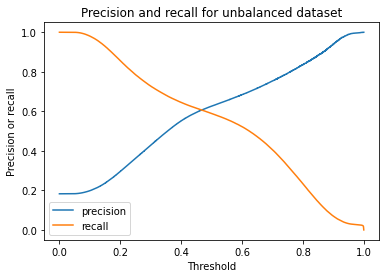

In [21]:
plot_pr_curve(y_test, vot_clf.predict_proba(X_test)[:,1])

Результат не превзошёл градиентный бустинг. Это обосновано тем, что оба классификатора показывают достаточно слабое качество. Поэтому нужно сосредоточится на новых признаках для повышения качества отдельных моделей, а не на ансамблеваемом обучении

### Визуализация классификации

In [19]:
def plot_scatter(model, X, y):
    train_x, test_x, train_y, test_y = train_test_split(X, y, shuffle=True, random_state=42)
    train_x = scaler.fit_transform(train_x.drop('DEP_DELAY', axis=1))
    model.fit(train_x, train_y)
    preds = model.predict(scaler.transform(test_x.drop('DEP_DELAY', axis=1)))
    test_x['preds'] = preds
    test_x['test'] = test_y
    
    plt.figure(figsize=(10,7))
    sns.scatterplot(x=range(len(test_x.iloc[:150,:])), y=test_x.iloc[:150, :]['DEP_DELAY'], 
                hue=test_x.iloc[:150, :]['preds'], style=test_y[:150])
    return model, X_test

<ipython-input-19-efccbb49f695>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x['preds'] = preds
<ipython-input-19-efccbb49f695>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x['test'] = test_y


CPU times: user 59.2 s, sys: 10.5 s, total: 1min 9s
Wall time: 1min 16s


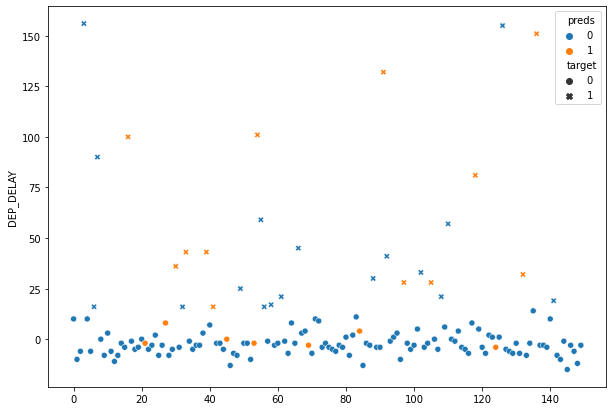

In [20]:
%%time
logit, _ = plot_scatter(LogisticRegression(max_iter=200),
            flights.drop(columns=['DEP_DELAY_GROUP', 'target']),
            flights.target)

[20:45:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<ipython-input-19-efccbb49f695>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x['preds'] = preds
<ipython-input-19-efccbb49f695>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x['test'] = test_y


CPU times: user 1h 15min 51s, sys: 25 s, total: 1h 16min 16s
Wall time: 10min 8s


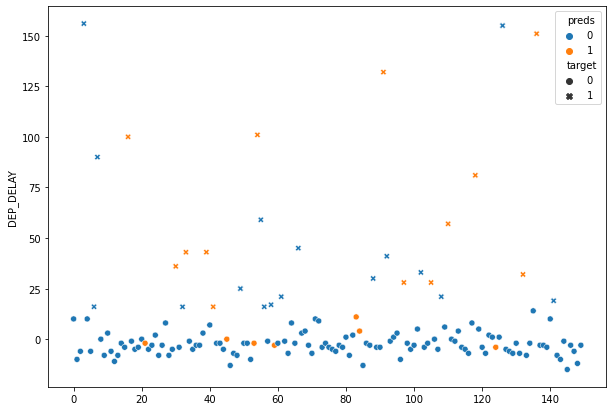

In [21]:
%%time
grad, _ = plot_scatter(XGBClassifier(random_state=42, n_jobs=6, use_label_encoder=False),
            flights.drop(columns=['DEP_DELAY_GROUP', 'target']),
            flights.target)

## Анализ результатов

Добавление новых признаков лучшим образом сказалось на качестве классификации. Но данных всё же не хватает для большой уверенности распознания больших задержек отправления. Такие важные данные как время технического обслуживания самолёта, время ожидания стыковочного рейса, время загрузки багажа, загруженность ВВП, скорее всего, не удастся раздобыть.